# Gallery

The gallery contains standard plots you can make with the `crdb` Python library, that you can install with `pip install crdb`.

In [1]:
import crdb
from crdb.mpl import draw_references, draw_table, draw_logo
from crdb.experimental import convert_energy
from crdb.units import TeV
import matplotlib.pyplot as plt
from matplotlib import cycler, colors as mcolors
from matplotlib.ticker import MultipleLocator, LogLocator
import numpy as np
from iminuit import Minuit
from iminuit.cost import LeastSquares

print(f"CRDB version {crdb.__version__}")

CRDB version 0.9.0


We define a common style for all plots.

In [2]:
cc = (
    # standard markers for our plots
    cycler(marker=["o", "s", "D", "v", "^", "<", ">"])
    * cycler(color=mcolors.TABLEAU_COLORS)
)

plt.rcParams["lines.markersize"] = 5
plt.rcParams["axes.prop_cycle"] = cc
plt.rcParams["figure.constrained_layout.use"] = True


def format_ten_power(val, _):
    x = np.log10(val)
    if abs(x) < 2:
        return f"{val:g}"
    return f"$10^{{{x:g}}}$"


savefig = True

# Jupyter magic command to show matplotlib plots as SVG images;
# produces crisp plots but notebook rendering may become very slow
# %config InlineBackend.figure_formats = ['svg']

## Boron to carbon ratio

We plot all data on B/C ratios in the DB and plot different experiments in different colors.

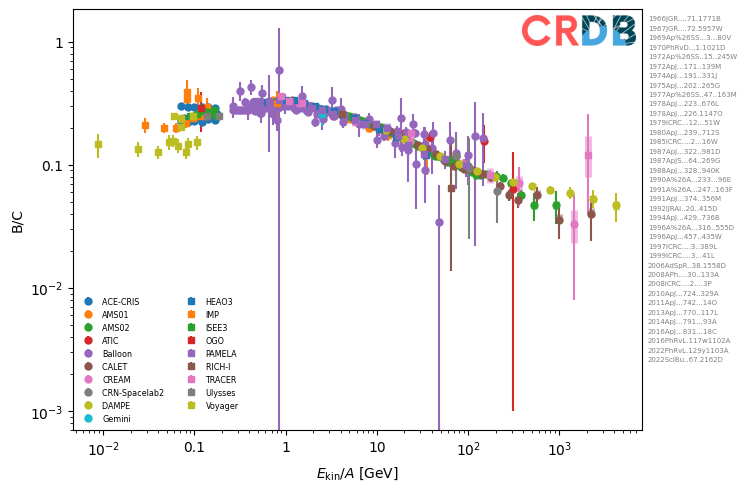

In [3]:
tab = crdb.query("B/C", energy_type="EKN")

plt.figure(constrained_layout=False)
plt.subplots_adjust(right=0.85, top=0.99, bottom=0.1)

# plot each experiment with different color
for exp, mask in crdb.experiment_masks(tab).items():
    t = tab[mask]
    if len(t) == 0:
        continue
    draw_table(t, label=exp)

plt.legend(ncol=2, frameon=False, loc="lower left", fontsize="xx-small")
plt.xlabel(r"$E_\mathrm{kin} / A$ [GeV]")
plt.ylabel("B/C")
plt.loglog()
plt.gca().xaxis.set_major_formatter(format_ten_power)
plt.gca().yaxis.set_major_formatter(format_ten_power)
draw_references(
    tab, loc="upper left", bbox_to_anchor=(1, 1), fontsize=5, columnspacing=0.3
)
draw_logo(0.78, 1)
if savefig:
    plt.savefig("figure/boron_to_carbon.svg")
    plt.savefig("figure/boron_to_carbon.pdf")

Now we show only experiments which have published both statistical and systematic uncertainties. This is an effective way to remove old data of uncertain quality.

We also fit the data with an empirical model that adds a Gaussian in log(energy)-space to a power law.

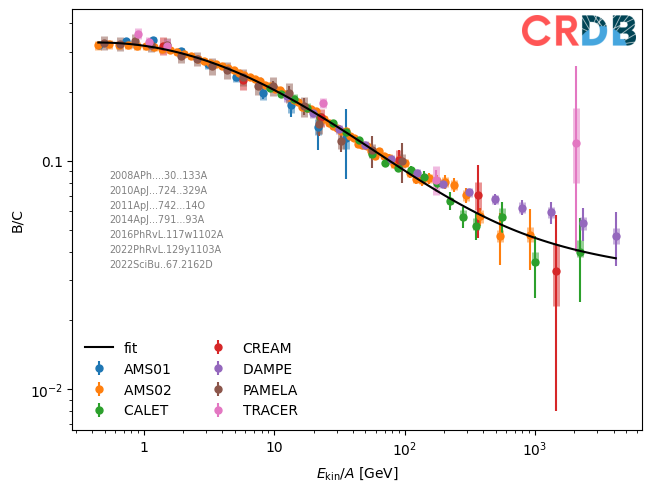

In [4]:
tab = crdb.query("B/C", energy_type="EKN")

# select only entries with systematic uncertainties
mask = tab.err_sys[:, 1] > 0
tab = tab[mask]

for exp, mask in crdb.experiment_masks(tab).items():
    t = tab[mask]
    draw_table(t, label=exp)

# fit data


def model(x, amp1, gamma, amp2, mu, sigma):
    return amp1 * x**gamma + amp2 * np.exp(
        -0.5 * (np.log(x) - np.log(mu)) ** 2 / sigma
    )


lsq = LeastSquares(tab.e, tab.value, np.mean(tab.err_sta, axis=1), model)

m = Minuit(lsq, amp1=0.3, gamma=-0.3, amp2=0.5, mu=1, sigma=1)
m.limits["amp1", "amp2", "sigma"] = (0, np.inf)
m.limits["mu"] = (0.1, 10)
m.limits["gamma"] = (-1, 0)
m.migrad()

# draw fit
xm = np.geomspace(np.min(tab.e), np.max(tab.e), 100)
plt.plot(xm, model(xm, *m.values), "-k", zorder=4, label="fit")

# add axis labels, references, legend, logo
plt.xlabel(r"$E_\mathrm{kin} / A$ [GeV]")
plt.ylabel("B/C")
plt.legend(ncol=2, frameon=False, loc="lower left")
plt.loglog()
plt.gca().xaxis.set_major_formatter(format_ten_power)
plt.gca().yaxis.set_major_formatter(format_ten_power)
draw_references(tab, loc="center left", bbox_to_anchor=(0.05, 0.5), fontsize="x-small")
draw_logo(0.78, 1)
if savefig:
    plt.savefig("figure/boron_to_carbon_2.svg")
    plt.savefig("figure/boron_to_carbon_2.pdf")

You can generate a list of URLs to the papers for the current table.

In [5]:
for url in crdb.reference_urls(tab):
    print(url)

https://ui.adsabs.harvard.edu/abs/2008APh....30..133A
https://ui.adsabs.harvard.edu/abs/2010ApJ...724..329A
https://ui.adsabs.harvard.edu/abs/2011ApJ...742...14O
https://ui.adsabs.harvard.edu/abs/2014ApJ...791...93A
https://ui.adsabs.harvard.edu/abs/2016PhRvL.117w1102A
https://ui.adsabs.harvard.edu/abs/2022PhRvL.129y1103A
https://ui.adsabs.harvard.edu/abs/2022SciBu..67.2162D


## Electron and positron fluxes

### Electrons + positrons

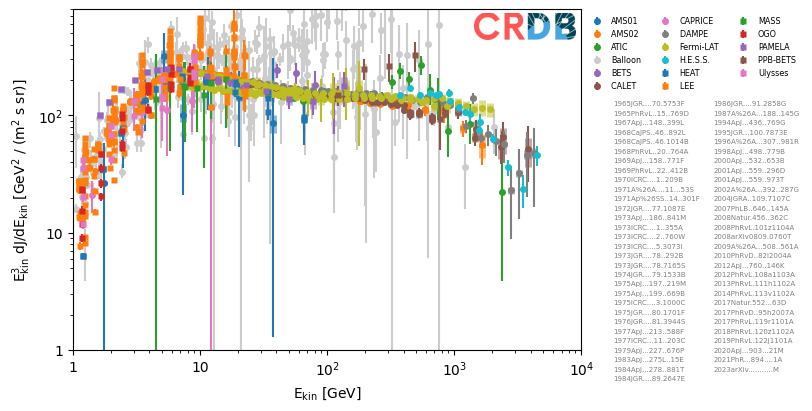

In [6]:
tab = crdb.query("e-+e+", energy_type="EK")

xlim = 1, 1e4
tab = tab[(xlim[0] < tab.e) & (tab.e < xlim[1])]

plt.figure(figsize=(8, 4))
for i, (exp, mask) in enumerate(crdb.experiment_masks(tab).items()):
    t = tab[mask]
    f = t.e**3
    if exp == "Balloon":
        zorder = 0
        color = "0.8"
    else:
        zorder = None
        color = None
    draw_table(t, factor=f, label=exp, zorder=zorder, mec="none", color=color)

plt.xlim(*xlim)
plt.ylim(1, 8e2)
plt.xlabel(r"E$_\mathrm{kin}$ [GeV]")
plt.ylabel(r"E$_\mathrm{kin}^3$ dJ/dE$_\mathrm{kin}$ [GeV$^2$ / (m$^2$ s sr)]")
plt.legend(fontsize="xx-small", ncol=3, frameon=False, bbox_to_anchor=(1, 1))
plt.loglog()
plt.gca().xaxis.set_major_formatter(format_ten_power)
plt.gca().yaxis.set_major_formatter(format_ten_power)
draw_references(tab, ncol=2, bbox_to_anchor=(1.05, 0.75), fontsize=5)
draw_logo(0.78, 1)
if savefig:
    plt.savefig("figure/electrons_and_positrons.svg")
    plt.savefig("figure/electrons_and_positrons.pdf")

### Positron fraction

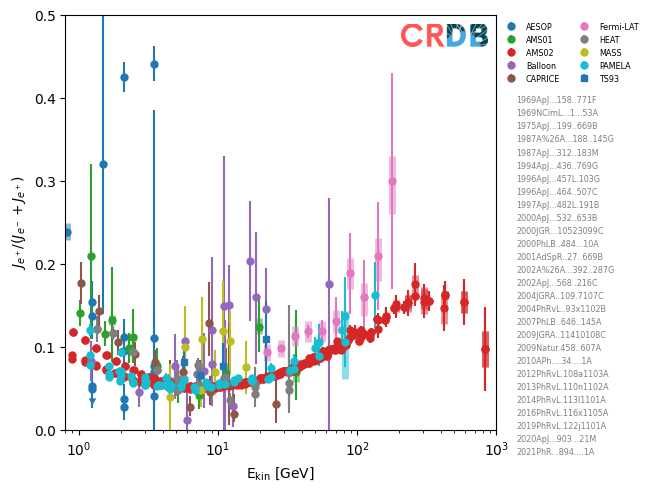

In [7]:
tab = crdb.query("e+/e-+e+", energy_type="EK")

xlim = 0.8, 1e3
tab = tab[(xlim[0] < tab.e) & (tab.e < xlim[1])]

for i, (exp, mask) in enumerate(crdb.experiment_masks(tab).items()):
    t = tab[mask]
    draw_table(t, label=exp)

plt.xlim(*xlim)
plt.ylim(0, 0.5)
plt.xlabel(r"E$_\mathrm{kin}$ [GeV]")
plt.ylabel("$J_{e^+} / (J_{e^-} + J_{e^+})$")
plt.legend(
    fontsize="xx-small",
    ncol=2,
    framealpha=1,
    bbox_to_anchor=(1, 1),
    frameon=False,
    loc="upper left",
)
plt.semilogx()
draw_references(tab, bbox_to_anchor=(1.03, -0.08), loc="lower left")
draw_logo(0.77, 1)
if savefig:
    plt.savefig("figure/positron_fraction.svg")
    plt.savefig("figure/positron_fraction.pdf")

### Electrons only, positrons only


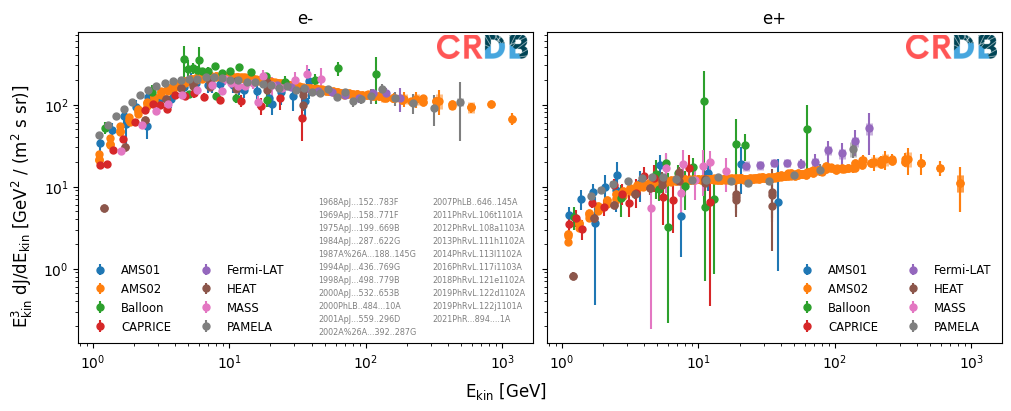

In [8]:
tab = crdb.query(("e-", "e+"), energy_type="EK")

xlim = 1, 1e4
tab = tab[(xlim[0] < tab.e) & (tab.e < xlim[1])]

fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
for quant, axi in zip(("e-", "e+"), ax):
    plt.sca(axi)
    tab2 = tab[tab["quantity"] == quant]
    for i, (exp, mask) in enumerate(crdb.experiment_masks(tab2).items()):
        t = tab2[mask]
        f = t.e**3
        draw_table(t, factor=f, label=exp)
        plt.title(quant)
fig.supxlabel(r"E$_\mathrm{kin}$ [GeV]")
fig.supylabel(r"E$_\mathrm{kin}^3$ dJ/dE$_\mathrm{kin}$ [GeV$^2$ / (m$^2$ s sr)]")
plt.loglog()
plt.sca(ax[0])
draw_references(tab, ncol=2, fontsize="xx-small", loc="lower right")
for axi in ax:
    plt.sca(axi)
    axi.legend(
        frameon=False,
        fontsize="small",
        ncol=2,
        loc="lower right" if axi is ax[1] else None,
    )
    draw_logo(0.78, 1)
if savefig:
    plt.savefig("figure/electrons_positrons.svg")
    plt.savefig("figure/electrons_positrons.pdf")

# Fluxes of nuclei

## Low-energy range

In [9]:
xlim = 1e-2, 1e6

elements = {
    "H": 0,
    "He": -2,
    "C": -4,
    "O": -6,
    "Ne": -8,
    "Mg": -10,
    "Si": -12,
    "S": -14,
    "Ar": -16,
    "Ca": -18,
    "Fe": -21,
}

# apply cuts:

# select table entries with our elements
tabs = []
for elem in elements:
    tabs.append(crdb.query(elem, energy_type="EKN"))

tab = np.concatenate(tabs).view(np.recarray)
# use our energy range
tab = tab[(xlim[0] < tab.e) & (tab.e < xlim[1])]
# we don't want upper limits
tab = tab[~tab.is_upper_limit]
# statistical errors less than 100 %
tab = tab[np.mean(tab.err_sta, axis=1) / tab.value < 1]
# skip balloon data
mask = crdb.experiment_masks(tab)["Balloon"]
tab = tab[~mask]

len(tab)

2967

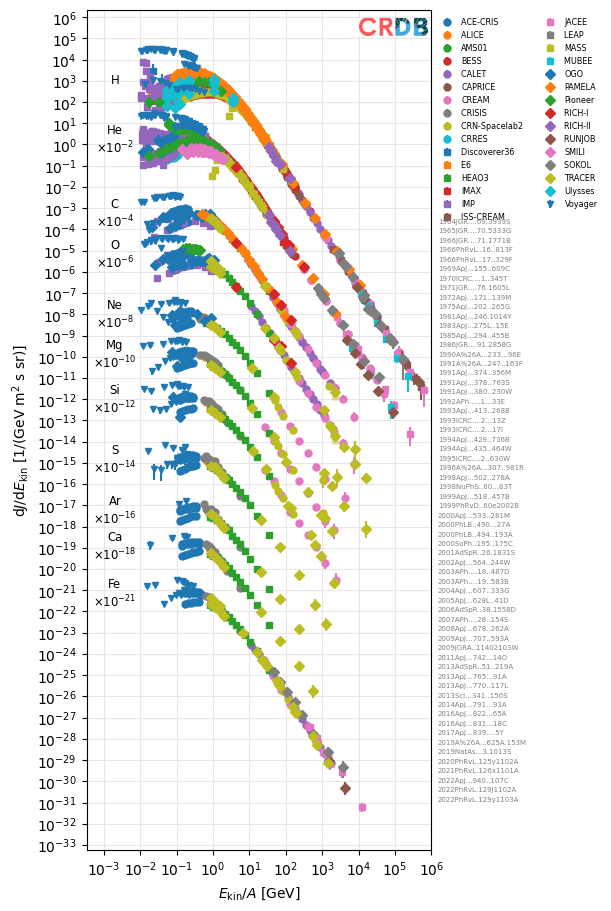

In [10]:
fig = plt.figure(figsize=(6, 9))
masks = crdb.experiment_masks(tab)
for exp in sorted(masks):
    t = tab[masks[exp]]
    first = True
    color = None
    marker = None
    for elem, fexp in elements.items():
        f = 10**fexp
        t2 = t[t.quantity == elem]
        if len(t2) == 0:
            continue
        l = draw_table(
            t2,
            factor=10**fexp,
            label=exp if first else None,
            color=color,
            marker=marker,
        )
        first = False
        color = l.get_color()
        marker = l.get_marker()

for elem, fexp in elements.items():
    t = tab[tab.quantity == elem]
    ymean = np.exp(np.mean(np.log(t[t.e < xlim[0] * 100].value))) * 10**fexp
    s = f"{elem}\n$\\times 10^{{{fexp}}}$" if fexp != 0 else f"{elem}"
    plt.text(2e-3, ymean, s, va="center", ha="center", fontsize="small")

plt.xlabel(r"$E_\mathrm{kin} / A$ [GeV]")
plt.ylabel(r"d$J$/d$E_\mathrm{kin}$ [1/(GeV m$^2$ s sr)]")
plt.legend(
    fontsize="xx-small", frameon=False, loc="upper left", ncol=2, bbox_to_anchor=(1, 1)
)
plt.grid(color="0.9")
plt.grid(which="minor", color="0.9")
plt.loglog()
plt.xlim(xlim[0] / 30, xlim[1])
plt.gca().yaxis.set_major_locator(LogLocator(numticks=100))
plt.gca().xaxis.set_major_locator(LogLocator(numticks=100))
draw_references(tab, fontsize=5, loc="lower left", bbox_to_anchor=(1, 0.03))
draw_logo(0.78, 1.03, zorder=5)
if savefig:
    plt.savefig("figure/low_energy_fluxes.svg")
    plt.savefig("figure/low_energy_fluxes.pdf")

## Full energy range

We plot the fluxes of several elements, electrons and positrons, and the all-particle flux measured by air shower experiments (which cannot distinguish individual elements, only groups) as function of total energy. Out of all available elements, only some datasets are available as function of total energy.

We skip data points without published systematic uncertainties. We further skip data points with more than 50 % statistical uncertainty. These cuts remove some elements from the table altogether.

The plot on the left(right)-hand side shows the flux scaled with $E$ ($E^{2.6}$). Flux levels are shown with different shades of gray for reference. One can see that direct measurements, which typically have apertures around 1 square-meter, stop to be practical when the flux drops below the threshold of 1 event per square-meter and day.

We plot data with `e_type == "EK"` and `e_type == "ETOT"` into the same graph. This is valid here since kinetic energy approaches total energy for high momenta. The corresponding warning can be ignored.

/usr/local/lib/python3.11/site-packages/crdb/mpl.py:51: RuntimeWarning: table contains potentially incompatbile e_types {'ETOT', 'EK'}
  warnings.warn(msg, RuntimeWarning)


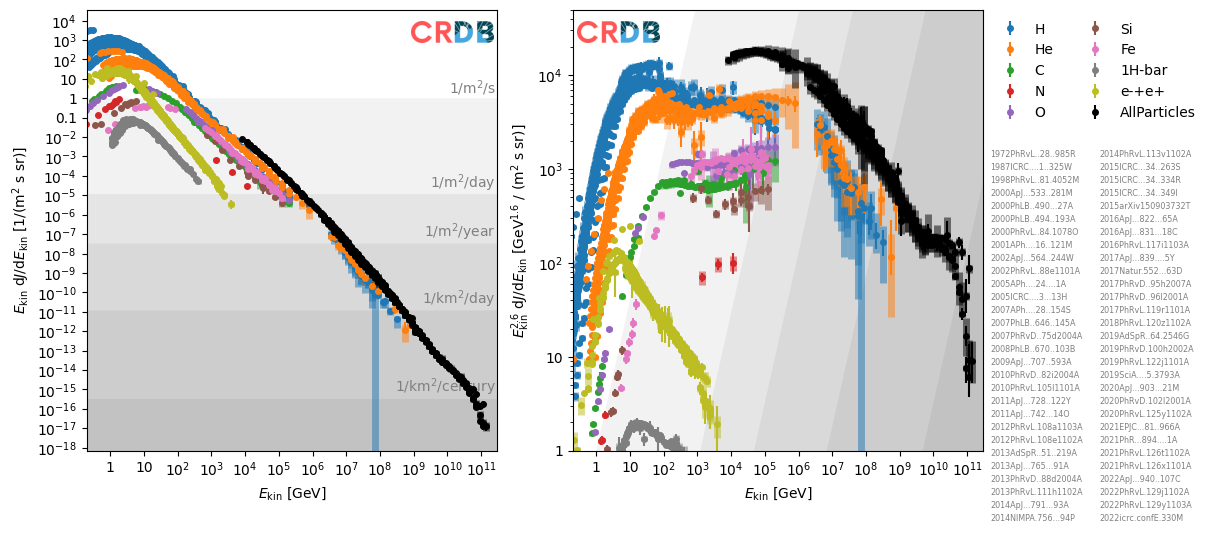

In [11]:
elements = ("H", "He", "C", "N", "O", "Si", "Fe")
elements += ("1H-bar", "e-+e+", "AllParticles")

tabs = []
for energy_type in ("EKN", "ETOT"):
    for elem in elements:
        tab = crdb.query(
            elem,
            energy_type=energy_type,
            energy_convert_level=1,
        )
        if energy_type == "EKN":
            tab = convert_energy(tab, "EK")
        tabs.append(tab)
tab = np.concatenate(tabs).view(np.recarray)

with np.errstate(divide="ignore"):
    mask = (tab.err_sys[:, 0] > 0) & (tab.err_sta[:, 0] / tab.value < 0.5)
tab = tab[mask]

exponents = (1, 2.6)

fig, ax = plt.subplots(1, 2, sharex=True, figsize=(12, 5))
for expo, axi in zip(exponents, ax):
    plt.sca(axi)
    for elem in elements:
        ma = tab.quantity == elem
        t = tab[ma]
        if len(t) == 0:
            continue
        f = t.e**expo
        color = "k" if elem == "AllParticles" else None
        draw_table(t, factor=f, color=color, label=elem, ms=4)
        if expo == 1:
            plt.ylabel("$E_\\mathrm{kin}$ d$J$/d$E_\\mathrm{kin}$ [1/(m$^2$ s sr)]")
        else:
            plt.ylabel(
                f"$E_\\mathrm{{kin}}^{{{expo}}}$ d$J$/d$E_\\mathrm{{kin}}$ "
                f"[GeV$^{{{expo - 1}}}$ / (m$^2$ s sr)]"
            )

m = 1
km = 1e3 * m
s = 1
hour = 60**2 * s
day = 24 * hour
month = 30 * day
year = 356 * day
century = 100 * year
x = np.geomspace(2e-1, 3e11, 1000)
for exponent, axi in zip(exponents, ax):
    axi.loglog()
    axi.set_xlabel("$E_\\mathrm{kin}$ [GeV]")
    axi.set_xlim(x[0], x[-1])
    for flux_ref in (
        "1/m^2/s",
        "1/m^2/day",
        "1/m^2/year",
        "1/km^2/day",
        "1/km^2/century",
    ):
        v = eval(flux_ref.replace("^2", "**2"))
        label = flux_ref.replace("^2", "$^2$")
        y = v * x ** (exponent - 1)
        axi.fill_between(x, y, color="k", zorder=0, alpha=0.05, lw=0)
        if axi is ax[0]:
            axi.text(
                x[-1] * 0.9,
                y[-1] * 1.1,
                label,
                va="bottom",
                ha="right",
                color="0.5",
                zorder=0,
            )

ax[1].legend(frameon=False, ncol=2, loc="upper left", bbox_to_anchor=(1, 1))
ax[1].set_ylim(1, 5e4)
draw_references(tab, bbox_to_anchor=(1, 0.7), ncol=2, loc="upper left")
plt.sca(ax[0])
ax[0].xaxis.set_major_locator(LogLocator(numticks=100))
ax[0].xaxis.set_major_formatter(format_ten_power)
ax[0].yaxis.set_major_locator(LogLocator(numticks=100))
ax[0].yaxis.set_major_formatter(format_ten_power)
ax[1].yaxis.set_major_formatter(format_ten_power)
draw_logo(0.78, 1)
plt.sca(ax[1])
draw_logo(0, 1)
if savefig:
    plt.savefig("figure/fluxes.svg")
    plt.savefig("figure/fluxes.pdf")

## Composition of high-energy cosmic-rays

We plot the composition of high-energy cosmic rays for experiments which measured four mass groups.

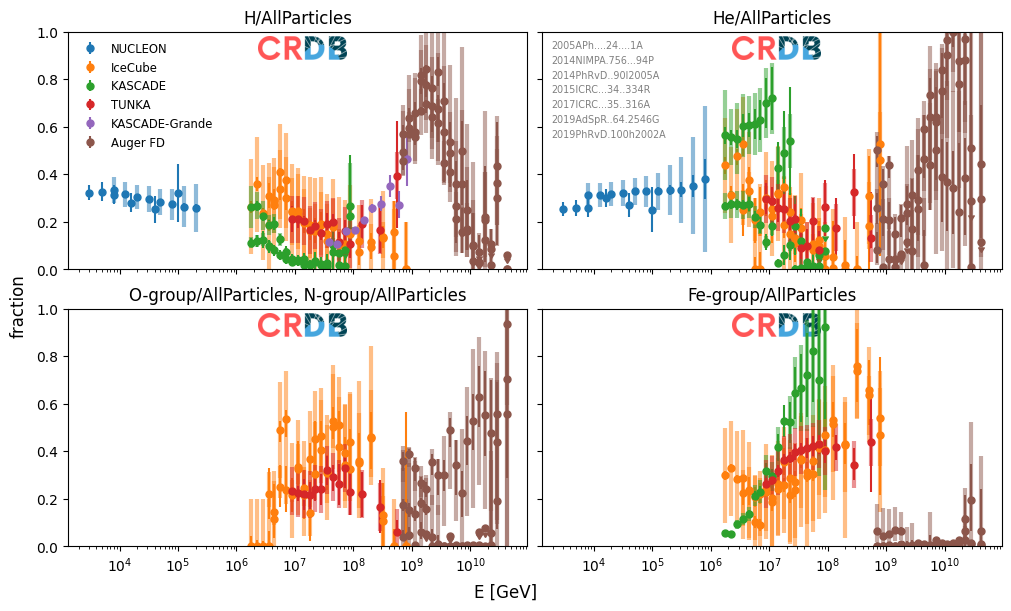

In [12]:
ratios = (
    "H/AllParticles",
    "He/AllParticles",
    "O-group/AllParticles",
    "N-group/AllParticles",
    "Fe-group/AllParticles",
)

tab = crdb.query(ratios, energy_type="ETOT", energy_convert_level=1)
tab = np.sort(tab, order=("e",))

fig, ax = plt.subplots(2, 2, figsize=(10, 6), sharex=True, sharey=True)

ratios = (
    "H/AllParticles",
    "He/AllParticles",
    ("O-group/AllParticles", "N-group/AllParticles"),
    "Fe-group/AllParticles",
)

for axi, ratio in zip(ax.flat, ratios):
    plt.sca(axi)
    if isinstance(ratio, tuple):
        ma = False
        for r in ratio:
            ma |= tab.quantity == r
    else:
        ma = tab.quantity == ratio
    for iexp, (exp, ma2) in enumerate(crdb.experiment_masks(tab).items()):
        t = tab[ma & ma2]
        draw_table(t, label=exp, color=f"C{iexp}", sys_lw=3)
    plt.title(ratio if isinstance(ratio, str) else ", ".join(ratio))

ax[0, 0].legend(fontsize="small", frameon=False)
fig.supxlabel("E [GeV]")
fig.supylabel("fraction")
plt.ylim(0, 1)
plt.semilogx()
plt.sca(ax[0, 1])
draw_references(tab, fontsize="x-small")
for axi in ax.flat:
    plt.sca(axi)
    draw_logo(0.4, 0.98)
if savefig:
    plt.savefig("figure/hecr_composition.svg")
    plt.savefig("figure/hecr_composition.pdf")

## Elemental abundances in cosmic rays and solar system

In [13]:
tab = crdb.all()

In [14]:
# get all quantities which contain elements in numerator and denominator
elements = []
ratios = []
for q in np.unique(tab.quantity):
    if "/" in q:
        num, den = q.split("/")
        if num in crdb.ELEMENTS and den in crdb.ELEMENTS:
            ratios.append(q)
    else:
        if q in crdb.ELEMENTS:
            elements.append(q)

# keep only ratios if no data is available for element in pure form
ratios = [x for x in ratios if (x.split("/")[0] not in elements)]

# apply cuts below

# select table entries with elements
mask = False
for q in elements + ratios:
    mask |= tab.quantity == q
tab = tab[mask]
# we don't want upper limits
tab = tab[~tab.is_upper_limit]
# statistical errors less than 100 %
tab = tab[np.mean(tab.err_sta, axis=1) / tab.value < 1]
# only measurements at 1 AU
tab = tab[tab.distance == 1]
# use EKN e_axis
tab = convert_energy(tab, "EKN")

# reference point for ratio measurement
xref = 20  # GeV
dlog10x = 0.5
xmin = 10 ** (np.log10(xref) - dlog10x)

# subset of table that we fit above minimum energy
tab_fit = tab[tab.e > xmin]

# ratios of ultra-heavy elements are below xmin, keep them separate
mask = False
for q in ratios:
    num, den = q.split("/")
    if den not in elements:
        continue
    mask |= tab.quantity == q
tab_ratio = tab[mask]

tab_all = np.concatenate([tab_fit, tab_ratio]).view(np.recarray)

Perform fits to get flux for each element at the reference point. The following plot is not for the public, it validates the fits.

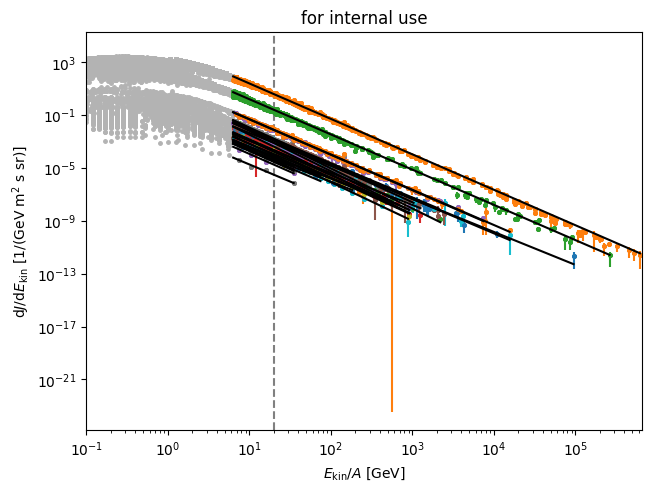

In [15]:
def model(x, log_j, gamma):
    return log_j - gamma * np.log(x / xref)


jref = {}

for q in elements:
    t = tab[tab.quantity == q]
    t2 = tab_fit[tab_fit.quantity == q]
    if len(t2) < 2:
        continue

    # prepare arrays for fitting
    x = t2.e
    y = t2.value
    ye1 = np.mean(t2.err_sta, axis=1)
    ye2 = np.mean(t2.err_sys, axis=1)
    ye = np.sqrt(ye1**2 + ye2**2)

    # get starting value for fit
    t3 = t2[np.abs(np.log10(t2.e) - np.log10(xref)) < dlog10x]
    log_j0 = np.mean(np.log(t3.value))

    # run least-squares fit using MINUIT
    c = LeastSquares(x, np.log(y), ye / y, model)
    m = Minuit(c, log_j0, 2.7)
    m.migrad()
    assert m.valid

    # generate points for the fitted line for validation
    xm = np.geomspace(xmin, np.max(t.e))
    ym = np.exp(model(xm, *m.values))

    # compute fitted flux at reference point and uncertainty,
    # apply chi2/ndof scaling of uncertainties to account for
    # systematic offsets between data sets
    jref1 = np.exp(m.values["log_j"])
    jref1_err = m.errors["log_j"] * jref1 * m.fmin.reduced_chi2**0.5
    jref[q] = (jref1, jref1_err)

    # plot everything
    plt.plot(t.e, t.value, ".", zorder=0, color="0.7")
    l = plt.plot(t2.e, t2.value, ".")[0]
    plt.errorbar(x, y, ye, fmt=".", color=l.get_color())
    plt.plot(xm, ym, "-k", zorder=4)

plt.xlim(1e-1, None)
plt.axvline(xref, color="0.5", ls="--")
plt.loglog()
plt.xlabel(r"$E_\mathrm{kin} / A$ [GeV]")
plt.ylabel(r"d$J$/d$E_\mathrm{kin}$ [1/(GeV m$^2$ s sr)]")
plt.title("for internal use");

Next, we visualize ratio data. This is not for the public but an internal plot for validation.

For the final plot, we compute the average ratio to get a single number if it was measured at several energies.

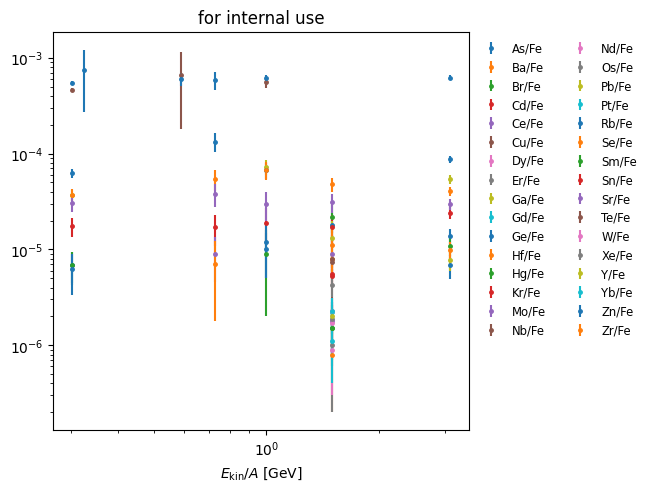

In [16]:
for q in ratios:
    t = tab_ratio[tab_ratio.quantity == q]
    if len(t) == 0:
        continue

    x = t.e
    y = t.value
    ye1 = np.mean(t.err_sta, axis=1)
    ye2 = np.mean(t.err_sys, axis=1)
    ye = np.sqrt(ye1**2 + ye2**2)

    plt.errorbar(x, y, ye, fmt=".", label=q)

    num, den = q.split("/")
    jden = jref[den][0]  # neglect uncertainty of denominator
    w = ye**-2
    cr = np.average(y, weights=w) * jden
    cre = np.sqrt(1 / np.sum(w)) * jden
    jref[num] = (cr, cre)

plt.legend(
    frameon=False, fontsize="small", ncol=2, bbox_to_anchor=(1, 1), loc="upper left"
)
plt.loglog()
plt.xlabel(r"$E_\mathrm{kin} / A$ [GeV]")
plt.title("for internal use");

Elemental abundances in cosmic rays at the reference energy compared to abundances in the solar system. The two sets of abundances are scaled so that silicon has a (arbitrary) abundance of $10^6$ in both sets.

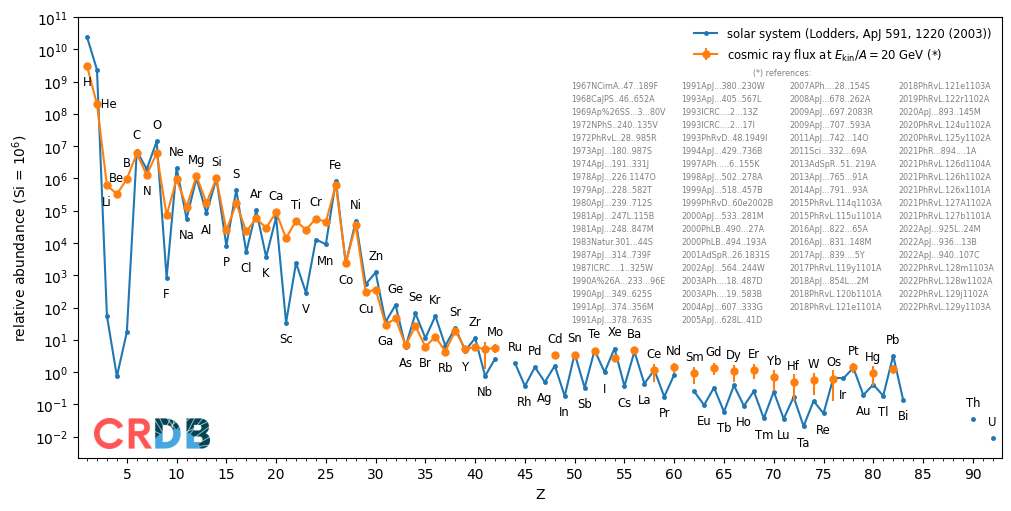

In [17]:
solar_system_composition = crdb.solar_system_composition()

# normalize cosmic ray abundances so that Si = 1e6
jref0 = jref["Si"][0]
scaling = 1e6 / jref0

data = []
for el, z in crdb.ELEMENTS.items():
    if el in solar_system_composition:
        isotopes = solar_system_composition[el]
        ss = sum(x[1] for x in isotopes)
    else:
        ss = np.nan
    cr, cre = jref.get(el, (np.nan, np.nan))
    data.append((z, cr * scaling, cre * scaling, ss))
data.sort(key=lambda x: x[0])

x, cr_y, cr_ye, ss_y = np.transpose(data)
elements = [[k for k, v in crdb.ELEMENTS.items() if v == z][0] for z in x]

plt.figure(figsize=(10, 5))
plt.plot(x, ss_y, "-", marker=".", label="solar system (Lodders, ApJ 591, 1220 (2003))")
plt.errorbar(
    x,
    cr_y,
    cr_ye,
    fmt="o-",
    label=f"cosmic ray flux at $E_\\mathrm{{kin}}/A = {xref}$ GeV (*)",
)
for eli, xi, yi, y2i in zip(elements, x, cr_y, ss_y):
    if np.isnan(yi) and np.isnan(y2i):
        continue
    if xi == 2:
        plt.text(xi, yi, f" {eli}", ha="left", va="center", fontsize="small")
        continue
    if xi == 3:
        plt.text(xi, yi * 0.5, f"{eli}", ha="center", va="top", fontsize="small")
        continue
    if xi % 2 == 1 and xi not in (5,):
        y = np.nanmin((yi, y2i)) * 0.5
        va = "top"
    else:
        y = np.nanmax((yi, y2i)) * 2
        va = "bottom"
    plt.text(xi, y, f"{eli}", ha="center", va=va, fontsize="small")
plt.legend(frameon=False, fontsize="small")
plt.xlim(0.1, np.max(x[~np.isnan(ss_y)]) + 0.9)
plt.xlabel("Z")
plt.ylabel("relative abundance (Si = $10^6$)")
plt.semilogy()
plt.gca().xaxis.set_major_locator(MultipleLocator(5))
plt.gca().xaxis.set_minor_locator(MultipleLocator())
plt.gca().yaxis.set_major_locator(LogLocator(numticks=100))
draw_references(
    tab_all,
    loc="upper right",
    bbox_to_anchor=(1, 0.9),
    title="(*) references:",
    fontsize="xx-small",
    ncol=4,
)
draw_logo(0, 0.09, height=0.07)
if savefig:
    plt.savefig("figure/cosmic_ray_vs_solar_abundances.svg")
    plt.savefig("figure/cosmic_ray_vs_solar_abundances.pdf")

## Time series

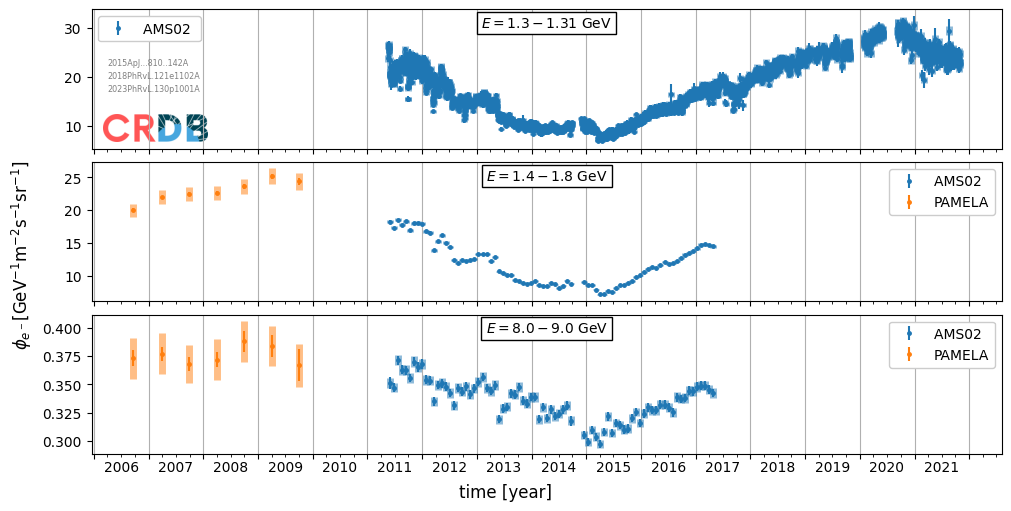

In [18]:
from datetime import date
import matplotlib.dates as mdates
from crdb.mpl import draw_timeseries

tab = crdb.query("e-", energy_type="Ek", time_series="only")

fig, axs = plt.subplots(3, 1, figsize=(10, 5), sharex=True)
erange = [
    [1.30, 1.31],
    [1.4, 1.8],
    [8.0, 9.0],
]  ## example for three energy ranges to be plotted
for ax, (elo, ehi) in zip(axs, erange):
    t1 = tab[
        (elo < tab["e"]) & (tab["e"] < ehi)
    ]  ## select data with mean energy in energy range
    for i, (exp, mask) in enumerate(crdb.experiment_masks(t1).items()):
        t2 = t1[mask]  ## select data from one experiment
        plt.sca(ax)
        draw_timeseries(t2, label=exp)  ## plot time series
    ax.text(
        0.5,
        0.95,
        f"$E = {elo}-{ehi}$ GeV",
        transform=ax.transAxes,
        verticalalignment="top",
        horizontalalignment="center",
        bbox=dict(boxstyle="square", facecolor="white"),
    )
    ax.xaxis.set_major_locator(mdates.YearLocator(base=1, month=1))
    ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=[1, 4, 7, 10]))
    ax.set_xticklabels([])  ## remove tick labels
    ax.grid(axis="x")  ## show x-grid only
    ax.legend(framealpha=1)
minyear = mdates.num2date(ax.get_xlim()[0]).year + 1  ## earliest year
maxyear = mdates.num2date(ax.get_xlim()[1]).year  ## latest year
for year in range(minyear, maxyear):
    axs[2].text(
        date(year, 7, 1),  ## plot year in centred position
        0.98 * axs[2].get_ylim()[0],
        "%d" % year,
        verticalalignment="top",
        horizontalalignment="center",
    )
fig.supxlabel("time [year]")
fig.supylabel(
    r"$J_{e^-} [\mathrm{GeV}^{-1}\mathrm{m}^{-2}\mathrm{s}^{-1}\mathrm{sr}^{-1}]$"
)
plt.sca(axs[0])
draw_references(
    tab,
    loc="upper left",
    bbox_to_anchor=(0.01, 0.7),
    fontsize="xx-small",
)
draw_logo(-0.14, 0.25, height=0.2)
if savefig:
    plt.savefig("figure/time_series.svg")
    plt.savefig("figure/time_series.pdf")

# Dipole

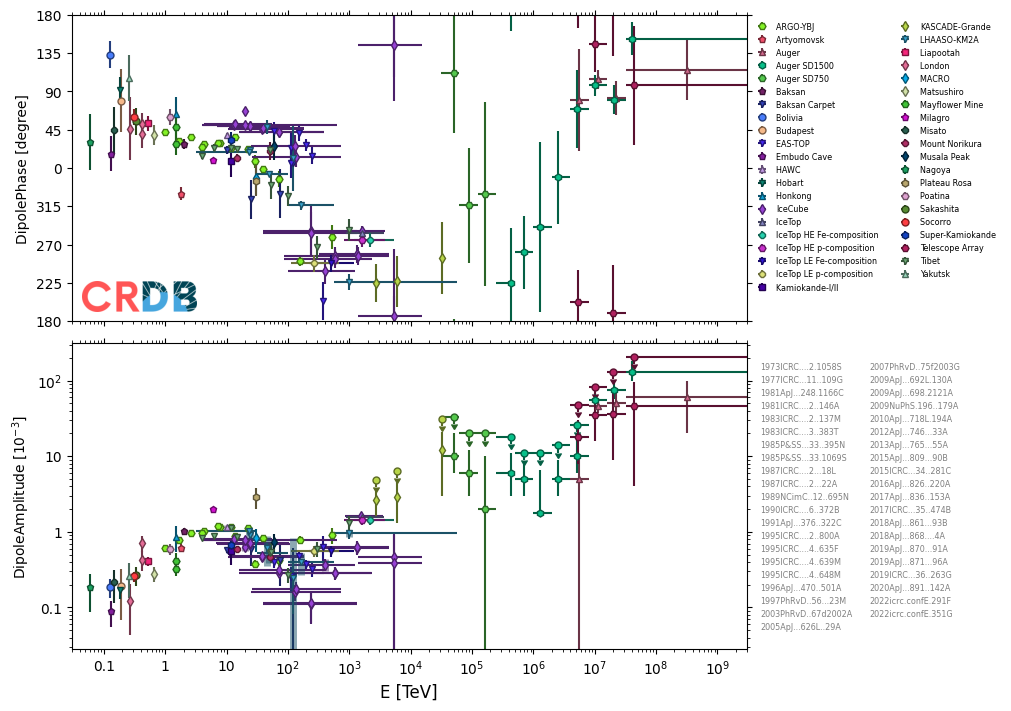

In [19]:
# crdb.query does not work yet with DipoleAmplitude and DipolePhase
tab = crdb.all()
tab = tab[(tab.quantity == "DipoleAmplitude") | (tab.quantity == "DipolePhase")]
exps = crdb.experiment_masks(tab)

# some random colors and symbols
rng = np.random.default_rng(1)
colors = rng.uniform(size=(len(exps), 3))
markers = ["o", "v", "^", "p", "h", "H", "d", "s", "8"]
markers = [rng.choice(markers) for _ in range(len(exps))]

fig, ax = plt.subplots(2, 1, figsize=(10, 7), sharex=True)

plt.sca(ax[0])
plt.ylim([-180, 180])
plt.ylabel(r"Dipole phase [degree]")

for (label, mask), marker, color in zip(exps.items(), markers, colors):
    t = tab[mask & (tab.quantity == "DipolePhase")]

    phase = (t.value + 180) % 360 - 180

    yerr = np.transpose(t.err_sta**2 + t.err_sys**2) ** 0.5
    xerr = np.abs(np.transpose(t.e_bin) - t.e)

    for shift in (-360, 0, 360):
        plt.errorbar(
            t.e / TeV,
            phase + shift,
            xerr=xerr / TeV,
            yerr=yerr,
            fmt=marker if shift == 0 else "none",
            color=color,
            ecolor=0.5 * color,
            markeredgecolor=0.5 * color,
            label=label if shift == 0 else None,
        )

    # TODO draw systematic error separately

plt.sca(ax[1])

for (_, mask), marker, color in zip(exps.items(), markers, colors):
    t = tab[mask & (tab.quantity == "DipoleAmplitude")]
    draw_table(
        t,
        factor=1e3,
        marker=marker,
        color=color,
        ecolor=0.5 * color,
        markeredgecolor=0.5 * color,
        show_bin=True,
        xunit=TeV,
    )

plt.loglog()
plt.ylabel(r"Dipole amplitude [$10^{-3}$]")
plt.xlabel(r"E [TeV]", fontsize="large")

ax[0].xaxis.set_major_locator(LogLocator(numticks=100))
ax[0].xaxis.set_minor_locator(LogLocator(subs="all", numticks=100))
ax[0].set_yticks(np.linspace(-180, 180, 9))
ax[0].yaxis.set_major_formatter(lambda val, _: f"{val % 360:.0f}")

ax[1].xaxis.set_major_formatter(format_ten_power)
ax[1].yaxis.set_major_formatter(format_ten_power)

plt.sca(ax[0])
plt.tick_params(which="both", top=True, right=True)
draw_logo(-0.01, 0.13)
plt.legend(
    bbox_to_anchor=(1, 1),
    fontsize="xx-small",
    loc="upper left",
    frameon=False,
    ncol=2,
)
plt.sca(ax[1])
plt.tick_params(which="both", top=True, right=True)
plt.xlim(0.03, 3e9)
draw_references(tab, bbox_to_anchor=(1.01, 0.96), ncol=2, loc="upper left")
if savefig:
    plt.savefig("figure/dipole.svg")
    plt.savefig("figure/dipole.pdf")